<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/hippocampus_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# Custom montage function
def custom_montage(images, n_rows=5, n_cols=5, cmap='gray'):
    """
    Create a montage (grid) of images.
    images: numpy array of shape (N, H, W) or (N, H, W, C)
    n_rows, n_cols: number of rows and columns in the grid
    cmap: colormap for displaying images
    """
    if images.shape[0] == 0:
        print("No images to display in montage.")
        return None
    n_images = min(images.shape[0], n_rows * n_cols)
    images = images[:n_images]
    if images.ndim == 4:
        images = images[..., 0]  # Use first channel for RGB images
    h, w = images.shape[1], images.shape[2]
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    ax = ax.ravel()
    for i in range(n_images):
        ax[i].imshow(images[i], cmap=cmap)
        ax[i].axis('off')
    for i in range(n_images, len(ax)):
        ax[i].axis('off')
    plt.tight_layout()
    return fig

# Unzip the dataset
!unzip -q "/content/hippocampus segmentation dataset.zip" -d "/content/hippocampus_dataset"

# Debug: Check unzipped contents
print("Dataset contents:")
!ls /content/hippocampus_dataset

# Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Seeding
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Define dataset paths (adjust based on actual structure after checking)
data = "/content/hippocampus_dataset/seghipp0/images"
data_left = "/content/hippocampus_dataset/seghipp0/masks/left"
data_right = "/content/hippocampus_dataset/seghipp0/masks/right"

# Load image and mask file paths
train_data = []
for dirName, _, fileList in sorted(os.walk(data)):
    for filename in fileList:
        if ".jpg" in filename.lower():
            train_data.append(os.path.join(dirName, filename))
print(f"Found {len(train_data)} image files.")

mask_left = []
for dirName, _, fileList in sorted(os.walk(data_left)):
    for filename in fileList:
        if ".jpg" in filename.lower():
            mask_left.append(os.path.join(dirName, filename))
print(f"Found {len(mask_left)} left mask files.")

mask_right = []
for dirName, _, fileList in sorted(os.walk(data_right)):
    for filename in fileList:
        if ".jpg" in filename.lower():
            mask_right.append(os.path.join(dirName, filename))
print(f"Found {len(mask_right)} right mask files.")

# Check if data is loaded
if not train_data or not mask_left or not mask_right:
    raise ValueError("No images or masks found. Check dataset paths.")

# Initialize arrays for training data
X_train = np.zeros((len(train_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_data), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Load and preprocess images
for file_index in tqdm(range(len(train_data)), desc="Loading images"):
    img = imread(train_data[file_index])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    img = img / 255.0
    X_train[file_index] = img

# Load and preprocess masks
for n in tqdm(range(min(len(mask_right), len(mask_left))), desc="Loading masks"):
    maskl = imread(mask_left[n], as_gray=True)
    maskr = imread(mask_right[n], as_gray=True)
    mask = np.maximum(maskl, maskr)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    mask = mask / 255.0
    Y_train[n] = mask

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

# Visualize a sample
if X_train.shape[0] > 0:
    id = min(10, X_train.shape[0] - 1)  # Ensure id is within bounds
    print(X_train[id].shape)
    plt.figure()
    imshow(X_train[id])
    plt.title("Sample Image")
    plt.show()
    plt.figure()
    imshow(Y_train[id][:, :, 0], cmap='gray')
    plt.title("Sample Mask")
    plt.show()
else:
    print("X_train is empty. Skipping visualization.")

# Shuffle and split data
if X_train.shape[0] > 1:  # Need at least 2 samples for train-test split
    X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
    print(f"X_train shape after split: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
else:
    print("Not enough data for train-test split. Using X_train as is.")
    X_test, Y_test = X_train, Y_train

# Visualize random sample
if X_train.shape[0] > 0:
    image_x = random.randint(0, X_train.shape[0] - 1)
    fig, ax = plt.subplots(1, 3, figsize=(16, 12))
    ax[0].imshow(X_train[image_x], cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(np.squeeze(Y_train[image_x]), cmap='gray')
    ax[1].set_title("Mask")
    ax[2].imshow(X_train[image_x], cmap='gray', interpolation='none')
    ax[2].imshow(np.squeeze(Y_train[image_x]), cmap='jet', interpolation='none', alpha=0.7)
    ax[2].set_title("Overlay")
    plt.show()
else:
    print("X_train is empty. Skipping random sample visualization.")

# Montage visualization
if X_train.shape[0] > 0:
    fig = custom_montage(X_train, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('MRI Input Images Samples')
        plt.show()
    fig = custom_montage(Y_train, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('Ground Truth Masks Samples')
        plt.show()

# Define Dice coefficient and loss
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Compile model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

# Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpointer
]

# Train model
if X_train.shape[0] > 0:
    results = model.fit(X_train, Y_train, validation_split=0.1, shuffle=True, batch_size=16, epochs=10, callbacks=callbacks)
else:
    print("X_train is empty. Skipping training.")

# Predictions
if X_train.shape[0] > 0 and X_test.shape[0] > 0:
    preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
    preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
    preds_test = model.predict(X_test, verbose=1)

    # Threshold predictions
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Visualize test sample
    id = random.randint(0, len(preds_test_t) - 1)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(X_test[id], cmap='gray')
    ax[0].set_title("X_test")
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(Y_test[id]), cmap='gray')
    ax[1].set_title("Y_test")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(preds_test_t[id]), cmap='gray')
    ax[2].set_title("Prediction")
    ax[2].axis('off')
    plt.show()

    # Visualize overlay
    fig, ax = plt.subplots(1, 4, figsize=(16, 12))
    ax[0].imshow(X_test[id], cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(np.squeeze(preds_test_t[id]), cmap='gray')
    ax[1].set_title("Predicted Mask")
    ax[2].imshow(np.squeeze(Y_test[id]), cmap='gray')
    ax[2].set_title("Ground Truth Mask")
    ax[3].imshow(X_test[id], cmap='gray', interpolation='none')
    ax[3].imshow(np.squeeze(preds_test_t[id]), cmap='jet', interpolation='none', alpha=0.7)
    ax[3].set_title("Overlay")
    plt.show()

# Montage of test data
if X_test.shape[0] > 0:
    fig = custom_montage(X_test, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('MRI Input Images Samples')
        plt.show()
    fig = custom_montage(Y_test, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('Ground Truth Masks Samples')
        plt.show()

# Plot predictions function
def plotPredictions(a, b, c, d, e):
    if a.shape[0] == 0 or c.shape[0] == 0:
        print("No data to predict. Skipping plotPredictions.")
        return
    model = e
    preds_train = model.predict(a[:int(a.shape[0] * 0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0] * 0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Training sample
    ix = random.randint(0, len(preds_train_t) - 1)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(a[ix], cmap='gray')
    ax[0].set_title("X_train")
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(b[ix]), cmap='gray')
    ax[1].set_title("Y_train")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')
    ax[2].set_title("Prediction")
    ax[2].axis('off')
    plt.show()

    # Validation sample
    ix = random.randint(0, len(preds_val_t) - 1)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(a[int(a.shape[0] * 0.9):][ix], cmap='gray')
    ax[0].set_title("X_val")
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(b[int(b.shape[0] * 0.9):][ix]), cmap='gray')
    ax[1].set_title("Y_val")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(preds_val_t[ix]), cmap='gray')
    ax[2].set_title("Prediction")
    ax[2].axis('off')
    plt.show()

if X_train.shape[0] > 0 and X_test.shape[0] > 0:
    plotPredictions(X_train, Y_train, X_test, Y_test, model)

# Plot training history
if 'results' in locals():
    acc = results.history.get('dice_coef', results.history.get('acc'))
    val_acc = results.history.get('val_dice_coef', results.history.get('val_acc'))
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training Dice Coef')
    plt.plot(epochs, val_acc, 'b', label='Validation Dice Coef')
    plt.title('Training and Validation Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

replace /content/hippocampus_dataset/aug/images/img_aug1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Dataset contents:
aug
Images folder:
img_aug100.jpg	img_aug191.jpg	img_aug281.jpg	img_aug371.jpg	img_aug461.jpg
img_aug101.jpg	img_aug192.jpg	img_aug282.jpg	img_aug372.jpg	img_aug462.jpg
img_aug102.jpg	img_aug193.jpg	img_aug283.jpg	img_aug373.jpg	img_aug463.jpg
img_aug103.jpg	img_aug194.jpg	img_aug284.jpg	img_aug374.jpg	img_aug464.jpg
img_aug104.jpg	img_aug195.jpg	img_aug285.jpg	img_aug375.jpg	img_aug465.jpg
img_aug105.jpg	img_aug196.jpg	img_aug286.jpg	img_aug376.jpg	img_aug466.jpg
img_aug106.jpg	img_aug197.jpg	img_aug287.jpg	img_aug377.jpg	img_aug467.jpg
img_aug107.jpg	img_aug198.jpg	img_aug288.jpg	img_aug378.jpg	img_aug468.jpg
img_aug108.jpg	img_aug199.jpg	img_aug289.jpg	img_aug379.jpg	img_aug469.jpg
img_aug109.jpg	img_aug19.jpg	img_aug28.jpg	img_aug37.jpg	img_aug46.jpg
img_aug10.jpg	img_aug1.jpg	img_aug290.jpg	img_aug380.jpg	img_aug470.jpg
img_aug110.jpg	img_aug200.jpg	img_aug291.jpg	img_aug381.jpg	img_aug471.jpg
img_aug111.jpg	img_aug201.jpg	img_aug292.jpg	img_aug382.jpg	img_aug472

Loading masks: 100%|██████████| 499/499 [00:03<00:00, 124.76it/s]
<ipython-input-2-ca3ea6f8c51d>:126: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[id])


X_train shape: (499, 128, 128, 3)
Y_train shape: (499, 128, 128, 1)
(128, 128, 3)


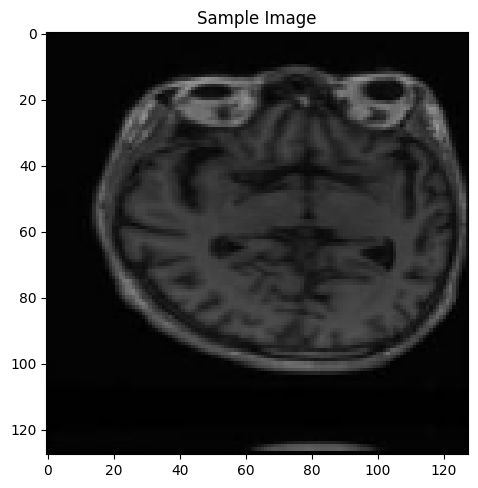

<ipython-input-2-ca3ea6f8c51d>:130: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(Y_train[id][:, :, 0], cmap='gray')
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


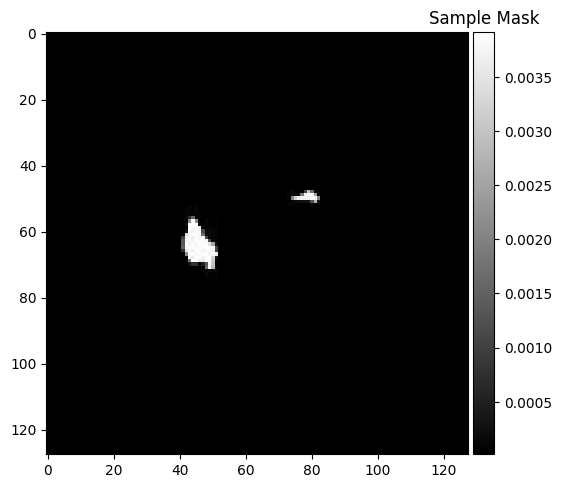

NameError: name 'shuffle' is not defined

In [2]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# Custom montage function
def custom_montage(images, n_rows=5, n_cols=5, cmap='gray'):
    """
    Create a montage (grid) of images.
    images: numpy array of shape (N, H, W) or (N, H, W, C)
    n_rows, n_cols: number of rows and columns in the grid
    cmap: colormap for displaying images
    """
    if images.shape[0] == 0:
        print("No images to display in montage.")
        return None
    n_images = min(images.shape[0], n_rows * n_cols)
    images = images[:n_images]
    if images.ndim == 4:
        images = images[..., 0]  # Use first channel for RGB images
    h, w = images.shape[1], images.shape[2]
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    ax = ax.ravel()
    for i in range(n_images):
        ax[i].imshow(images[i], cmap=cmap)
        ax[i].axis('off')
    for i in range(n_images, len(ax)):
        ax[i].axis('off')
    plt.tight_layout()
    return fig

# Unzip the dataset
!unzip -q "/content/hippocampus segmentation dataset.zip" -d "/content/hippocampus_dataset"

# Debug: Check unzipped contents
print("Dataset contents:")
!ls /content/hippocampus_dataset
print("Images folder:")
!ls /content/hippocampus_dataset/aug/images
print("Left masks folder:")
!ls /content/hippocampus_dataset/aug/masks/left
print("Right masks folder:")
!ls /content/hippocampus_dataset/aug/masks/right

# Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Seeding
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Define dataset paths
data = "/content/hippocampus_dataset/aug/images"
data_left = "/content/hippocampus_dataset/aug/masks/left"
data_right = "/content/hippocampus_dataset/aug/masks/right"

# Load image and mask file paths
train_data = []
for dirName, _, fileList in sorted(os.walk(data)):
    for filename in fileList:
        if ".jpg" in filename.lower():
            train_data.append(os.path.join(dirName, filename))
print(f"Found {len(train_data)} image files.")

mask_left = []
for dirName, _, fileList in sorted(os.walk(data_left)):
    for filename in fileList:
        if ".jpg" in filename.lower():
            mask_left.append(os.path.join(dirName, filename))
print(f"Found {len(mask_left)} left mask files.")

mask_right = []
for dirName, _, fileList in sorted(os.walk(data_right)):
    for filename in fileList:
        if ".jpg" in filename.lower():
            mask_right.append(os.path.join(dirName, filename))
print(f"Found {len(mask_right)} right mask files.")

# Check if data is loaded
if not train_data or not mask_left or not mask_right:
    raise ValueError("No images or masks found. Check dataset paths.")

# Initialize arrays for training data
X_train = np.zeros((len(train_data), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_data), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Load and preprocess images
for file_index in tqdm(range(len(train_data)), desc="Loading images"):
    img = imread(train_data[file_index])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)
    img = img / 255.0
    X_train[file_index] = img

# Load and preprocess masks
num_masks = min(len(mask_right), len(mask_left), len(train_data))
for n in tqdm(range(num_masks), desc="Loading masks"):
    maskl = imread(mask_left[n], as_gray=True)
    maskr = imread(mask_right[n], as_gray=True)
    mask = np.maximum(maskl, maskr)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    mask = mask / 255.0
    Y_train[n] = mask

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

# Visualize a sample
if X_train.shape[0] > 0:
    id = min(10, X_train.shape[0] - 1)  # Ensure id is within bounds
    print(X_train[id].shape)
    plt.figure()
    imshow(X_train[id])
    plt.title("Sample Image")
    plt.show()
    plt.figure()
    imshow(Y_train[id][:, :, 0], cmap='gray')
    plt.title("Sample Mask")
    plt.show()
else:
    print("X_train is empty. Skipping visualization.")

# Shuffle and split data
if X_train.shape[0] > 1:  # Need at least 2 samples for train-test split
    X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
    print(f"X_train shape after split: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
else:
    print("Not enough data for train-test split. Using X_train as is.")
    X_test, Y_test = X_train, Y_train

# Visualize random sample
if X_train.shape[0] > 0:
    image_x = random.randint(0, X_train.shape[0] - 1)
    fig, ax = plt.subplots(1, 3, figsize=(16, 12))
    ax[0].imshow(X_train[image_x], cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(np.squeeze(Y_train[image_x]), cmap='gray')
    ax[1].set_title("Mask")
    ax[2].imshow(X_train[image_x], cmap='gray', interpolation='none')
    ax[2].imshow(np.squeeze(Y_train[image_x]), cmap='jet', interpolation='none', alpha=0.7)
    ax[2].set_title("Overlay")
    plt.show()
else:
    print("X_train is empty. Skipping random sample visualization.")

# Montage visualization
if X_train.shape[0] > 0:
    fig = custom_montage(X_train, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('MRI Input Images Samples')
        plt.show()
    fig = custom_montage(Y_train, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('Ground Truth Masks Samples')
        plt.show()

# Define Dice coefficient and loss
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Compile model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

# Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpointer
]

# Train model
if X_train.shape[0] > 0:
    results = model.fit(X_train, Y_train, validation_split=0.1, shuffle=True, batch_size=16, epochs=10, callbacks=callbacks)
else:
    print("X_train is empty. Skipping training.")

# Predictions
if X_train.shape[0] > 0 and X_test.shape[0] > 0:
    preds_train = model.predict(X_train[:int(X_train.shape[0] * 0.9)], verbose=1)
    preds_val = model.predict(X_train[int(X_train.shape[0] * 0.9):], verbose=1)
    preds_test = model.predict(X_test, verbose=1)

    # Threshold predictions
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Visualize test sample
    id = random.randint(0, len(preds_test_t) - 1)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(X_test[id], cmap='gray')
    ax[0].set_title("X_test")
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(Y_test[id]), cmap='gray')
    ax[1].set_title("Y_test")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(preds_test_t[id]), cmap='gray')
    ax[2].set_title("Prediction")
    ax[2].axis('off')
    plt.show()

    # Visualize overlay
    fig, ax = plt.subplots(1, 4, figsize=(16, 12))
    ax[0].imshow(X_test[id], cmap='gray')
    ax[0].set_title("Image")
    ax[1].imshow(np.squeeze(preds_test_t[id]), cmap='gray')
    ax[1].set_title("Predicted Mask")
    ax[2].imshow(np.squeeze(Y_test[id]), cmap='gray')
    ax[2].set_title("Ground Truth Mask")
    ax[3].imshow(X_test[id], cmap='gray', interpolation='none')
    ax[3].imshow(np.squeeze(preds_test_t[id]), cmap='jet', interpolation='none', alpha=0.7)
    ax[3].set_title("Overlay")
    plt.show()

# Montage of test data
if X_test.shape[0] > 0:
    fig = custom_montage(X_test, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('MRI Input Images Samples')
        plt.show()
    fig = custom_montage(Y_test, n_rows=5, n_cols=5, cmap='gray')
    if fig:
        plt.title('Ground Truth Masks Samples')
        plt.show()

# Plot predictions function
def plotPredictions(a, b, c, d, e):
    if a.shape[0] == 0 or c.shape[0] == 0:
        print("No data to predict. Skipping plotPredictions.")
        return
    model = e
    preds_train = model.predict(a[:int(a.shape[0] * 0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0] * 0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    # Training sample
    ix = random.randint(0, len(preds_train_t) - 1)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(a[ix], cmap='gray')
    ax[0].set_title("X_train")
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(b[ix]), cmap='gray')
    ax[1].set_title("Y_train")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')
    ax[2].set_title("Prediction")
    ax[2].axis('off')
    plt.show()

    # Validation sample
    ix = random.randint(0, len(preds_val_t) - 1)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(a[int(a.shape[0] * 0.9):][ix], cmap='gray')
    ax[0].set_title("X_val")
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(b[int(b.shape[0] * 0.9):][ix]), cmap='gray')
    ax[1].set_title("Y_val")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(preds_val_t[ix]), cmap='gray')
    ax[2].set_title("Prediction")
    ax[2].axis('off')
    plt.show()

if X_train.shape[0] > 0 and X_test.shape[0] > 0:
    plotPredictions(X_train, Y_train, X_test, Y_test, model)

# Plot training history
if 'results' in locals():
    acc = results.history.get('dice_coef', results.history.get('acc'))
    val_acc = results.history.get('val_dice_coef', results.history.get('val_acc'))
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training Dice Coef')
    plt.plot(epochs, val_acc, 'b', label='Validation Dice Coef')
    plt.title('Training and Validation Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()